In [1]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word

from sentence_transformers import SentenceTransformer

from scipy.cluster import  hierarchy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
#clas to load the dataset and perform some data preprocessing. This class also outputs the number of unique uids in the dataset
class Load_Preprocess():

  def __init__(self,directory):
    self.directory = directory

  def load_data(self):
    df = pd.read_csv(self.directory)
    df.rename(columns={'Extracted problems':'extracted_problems'},inplace=True)
    return df

  def preprocess(self, df):
    #making all the letters lowercase
    df['extracted_problems'] = [text.lower() for text in df['extracted_problems']]

    #removing punctuations
    df['extracted_problems'] = df['extracted_problems'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

    #removing stop words
    stop = stopwords.words('english')
    df['extracted_problems'] = df['extracted_problems'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #performing lemmatization to change the words in their base forms
    df['extracted_problems'] = df['extracted_problems'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    #removing extra spaces
    df["extracted_problems"] = df["extracted_problems"].apply(lambda text: re.sub(' +', ' ', text))
    return df

  def unique_uid(self, df):
    #finding the number of unique uid in the dataset
    #all the uids are different from each other
    #so I have considered the first 2 letters of all the uids
    #as there are total 6 unique first two letters of the uid, considered 6 unique uid
    #so all the records now belong to these 6 categories or labels or uids
    #the next step is to cluster the respective records of these 6 labels
    uid_2 = []
    uid_2 = [i[0:2] for i in df['uid']]
    uid_set = set(uid_2)
    unique_uid = len(uid_set)
    print('Unique uids are:')
    print(uid_set)
    print('Total number of unique uid: ' + str(unique_uid))


In [3]:
#this class creates the sentence embeddings of the extracted_problems belonging to a particular label/uid
class Sentence_Embedding():

  def __init__(self, df, uid, model):
    #uid will be either WO, DE, EP, US, JP or CN at a time
    self.df = df
    self.uid = uid
    self.model = model

  def uid_problem_pair(self):
    #creating a dictionary of {uid (uid staring with either WO, DE, EP, US, JP or CN), extracted_problem}
    dict_problems = {}
    for i in range(len(self.df['uid'])):
      if self.df['uid'][i][0:2] == self.uid:
        dict_problems[self.df['uid'][i]] = self.df['extracted_problems'][i]
    print('Number of records under uid starting with ' + self.uid + ' is ' + str(len(list(dict_problems.keys()))))
    return dict_problems

  def sentence_embed(self, dict_problems):
    #sentence embedding using either BERT or MPNet
    #a sentence is first converted to 512 tokens
    #each token generates a vector of 768 values
    #finally a pooling layer will convert a 512x768 tensor to (1x768) vector for each sentence

    if self.model == 'bert':
      model = SentenceTransformer('bert-base-nli-mean-tokens')
      sentence_embeddings = model.encode(list(dict_problems.values()))

    elif self.model == 'mpnet':
      model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
      sentence_embeddings = model.encode(list(dict_problems.values()))
    
    print("Shape of " + str(len(list(dict_problems.keys()))) + " embedded sentences is " + str(sentence_embeddings.shape))
    return self.uid, sentence_embeddings



In [4]:
#this class draws dendogram and kmeans clusters in a scatterplot for a particular type of uid(uid strating with either WO, DE, EP, US, JP or CN)
class Clustering_Visualization():

  def __init__(self, uid_sentence_embed_pair):

    self.uid = uid_sentence_embed_pair[0]
    self.embed_matrix = uid_sentence_embed_pair[1]
    #setting the number of classes for each type of UID seperately for more use control
    if uid_sentence_embed_pair[0] == 'WO':
      self.clusters = 2
    elif uid_sentence_embed_pair[0] == 'DE':
      self.clusters = 4
    elif uid_sentence_embed_pair[0] == 'EP':
      self.clusters = 6
    elif uid_sentence_embed_pair[0] == 'US':
      self.clusters = 5
    elif uid_sentence_embed_pair[0] == 'JP':
      self.clusters = 2
    elif uid_sentence_embed_pair[0] == 'CN':
      self.clusters = 6
    

  def dendrogram_draw(self):

    # Performs hierarchical/agglomerative clustering based on Ward variance minimization algorithm
    hier_link = hierarchy.linkage(self.embed_matrix, method="average", metric = "cosine")
    print("Hierarchical clustering of records whose uid start with " + self.uid)
    plt.figure(figsize=(20, 20))
    #labelList = range(1, 256)
    dn = hierarchy.dendrogram(hier_link, orientation='right',
                distance_sort='descending')

    plt.title('Dendogram')
    plt.ylabel('Cosine Similarity')
    plt.show()
  
  def k_means_labels(self, uid_problem_pair):
    #shows the cluster numbers of each record for a particular type( WO, DE, EP, US, JP or CN)
    n_clusters = self.clusters
    if self.uid == 'CN':
      max_iter = 4000
    elif self.uid == 'WO':
      max_iter = 500
    elif self.uid == 'DE':
      max_iter = 2000
    elif self.uid == 'EP':
      max_iter = 4000
    elif self.uid == 'US':
      max_iter = 3000
    elif self.uid == 'JP':
      max_iter = 500
    clf = KMeans(n_clusters=n_clusters, max_iter=max_iter,init = 'k-means++', n_init=1) 
    labels = clf.fit_predict(self.embed_matrix)
    print("Printing the cluster labels for all the records whose uid start with " + uid_sentence_embed_pair[0] + " total record number under this category is " + str(len(list(uid_problem_pair.keys()))) + "\n") 
    print(labels) 
    for index, sentence in enumerate(list(uid_problem_pair.values())): 
      print(str(labels[index]) + ":  UID:" + str(list(uid_problem_pair.keys())[index]) + "     Problem:" + str(sentence) )
    return labels, clf

  def k_means_clustering(self, labels, clf):
    #clusters are plotted using Principal Component Analysis
    print("Scatter plot for records whose uid start with " + self.uid + "\n")
    pca = PCA(n_components=self.clusters).fit(self.embed_matrix) 
    coords = pca.transform(self.embed_matrix) 
    label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", "#D2CA0D", "#522A64", "#A3DB05", "#FC6514", "#DAF7A6" , "#581845"] 
    colors = [label_colors[i] for i in labels] 
    print("Records with their respective cluster labels are plotted using a Scatter plot." +"\n"+ "For dimentionality reduction of matrix containing sentence embeddings, we have used Principal Component Analysis." + "\n" +" X denotes cluster centers in the scatter plot." )
    plt.scatter(coords[:, 0], coords[:, 1], c = colors) 
    centroids = clf.cluster_centers_ 
    centroid_coords = pca.transform(centroids) 
    plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d61')
    plt.show()

In [5]:
directory = './Dataset_Clusterin_Problems.csv'
load_preprocess = Load_Preprocess(directory)
df = load_preprocess.load_data()

In [6]:
#showing the first 20 rows of the dataset before applying preprocessing techniques
df[0:20]

,uid,text,extracted_problems
0,US20200059181A1,One drawback of permanent magnet generators is...,vibration and noise
1,WO2019201595A1,In such de sign the double layer winding layou...,difficult to insert coils with narrow coil wid...
2,DE102009032881A1,By the increasing size of wind power generator...,their assembly is increasingly difficult; tra...
3,EP3273578B1,"Therefore, much effort is invested in the deve...",efficient cooling is made difficult by the com...
4,EP3531540A1,The object of the present invention is to impr...,the cooling of an electrical generator
5,CN102684348B,Can by with high-frequency come one or more co...,risk of converter failure
6,CN103671487B,Wind turbine（Especially directly drive wind tu...,It is very heavy. This to be very difficult to...
7,US8629596B2,In a conventional design of the stator slots o...,makes laying the form - wound coils in the slo...
8,CN103452758B,"In the case where aerodynamic brakes fail, mec...",aerodynamic brakes fail
9,EP2896824B1,One of the challenges with the direct drive ge...,mechanical brake system


In [7]:
#showing the first 20 rows of the dataset after applying preprocessing techniques
df = load_preprocess.preprocess(df)
df[0:20]

,uid,text,extracted_problems
0,US20200059181A1,One drawback of permanent magnet generators is...,vibration noise
1,WO2019201595A1,In such de sign the double layer winding layou...,difficult insert coil narrow coil width side s...
2,DE102009032881A1,By the increasing size of wind power generator...,assembly increasingly difficult transport logi...
3,EP3273578B1,"Therefore, much effort is invested in the deve...",efficient cooling made difficult compact desig...
4,EP3531540A1,The object of the present invention is to impr...,cooling electrical generator
5,CN102684348B,Can by with high-frequency come one or more co...,risk converter failure
6,CN103671487B,Wind turbine（Especially directly drive wind tu...,heavy difficult replace base bearing
7,US8629596B2,In a conventional design of the stator slots o...,make laying form wound coil slot difficult
8,CN103452758B,"In the case where aerodynamic brakes fail, mec...",aerodynamic brake fail
9,EP2896824B1,One of the challenges with the direct drive ge...,mechanical brake system


In [8]:
df_unique_labels = load_preprocess.unique_uid(df)

Unique uids are:
{'DE', 'WO', 'US', 'EP', 'JP', 'CN'}
Total number of unique uid: 6


##There are total 6 unique uids based on the first two letters of the uids. These uids start with either 'EP', 'CN', 'WO', 'JP', 'DE' or 'US'. So, I have considered 6 unique uids. The next four blocks corresponds to showing dendogram, extracted_problems and their cluster numbers and a scatter plot of K-means clustering for uids staring with CN. 

In [9]:
#specifying mpnet as embedding technique. Another option the user can select is bert.
#caution: running this will download some trained weights for performing the sentence embedding operations
embed = Sentence_Embedding(df, 'CN', 'mpnet')
uid_problem_pair = embed.uid_problem_pair()
uid_sentence_embed_pair = embed.sentence_embed(uid_problem_pair)

Number of records under uid starting with CN is 59
Shape of 59 embedded sentences is (59, 768)


Hierarchical clustering of records whose uid start with CN


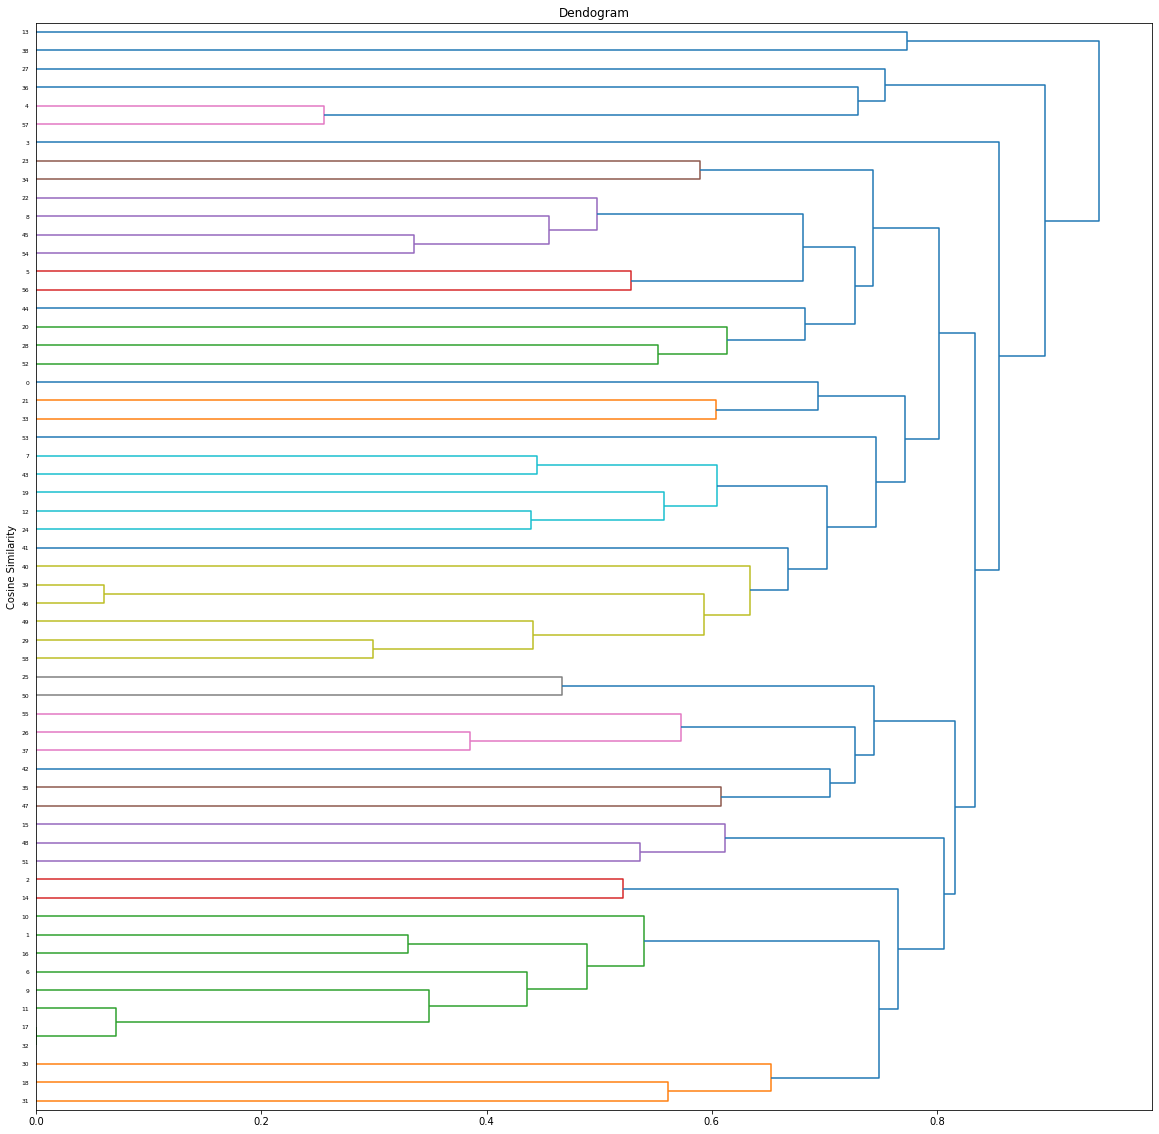

In [10]:
clustering = Clustering_Visualization(uid_sentence_embed_pair)
clustering.dendrogram_draw()

In [11]:
labels_out = clustering.k_means_labels(uid_problem_pair)

Printing the cluster labels for all the records whose uid start with CN total record number under this category is 59

[5 0 1 2 1 3 0 5 5 0 0 0 3 2 1 5 0 0 0 1 5 5 5 4 1 0 0 1 5 5 0 0 0 2 4 0 2
 0 1 3 5 3 3 5 0 2 3 0 0 5 0 4 5 5 5 5 1 1 5]
5:  UID:CN102684348B     Problem:risk converter failure
0:  UID:CN103671487B     Problem:heavy difficult replace base bearing
1:  UID:CN103452758B     Problem:aerodynamic brake fail
2:  UID:CN105305452B     Problem:difficult aware currently reduction grid condition
1:  UID:CN104949625B     Problem:visual inspection air gap
3:  UID:CN109979705A     Problem:increasing magnetic flux
0:  UID:CN107191474A     Problem:bearing extra fatigue
5:  UID:CN104995399B     Problem:transport part turbine become difficult
5:  UID:CN102290886B     Problem:difficult owing cooling water pipe stator coil winding separated
0:  UID:CN110131105A     Problem:uneven operation bearing
0:  UID:CN103453011B     Problem:optimal lubrication protecting bearing challenge task
0:  UI

Scatter plot for records whose uid start with CN

Records with their respective cluster labels are plotted using a Scatter plot.
For dimentionality reduction of matrix containing sentence embeddings, we have used Principal Component Analysis.
 X denotes cluster centers in the scatter plot.


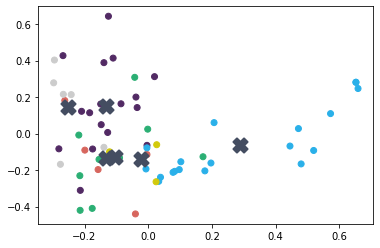

In [12]:
clustering.k_means_clustering(labels = labels_out[0], clf = labels_out[1])

##The next four blocks corresponds to showing dendogram, extracted_problems and their cluster numbers and a scatter plot of K-means clustering for uids staring with WO. 

In [13]:
embed = Sentence_Embedding(df, 'WO', 'mpnet')
uid_problem_pair = embed.uid_problem_pair()
uid_sentence_embed_pair = embed.sentence_embed(uid_problem_pair)

Number of records under uid starting with WO is 9
Shape of 9 embedded sentences is (9, 768)


Hierarchical clustering of records whose uid start with WO


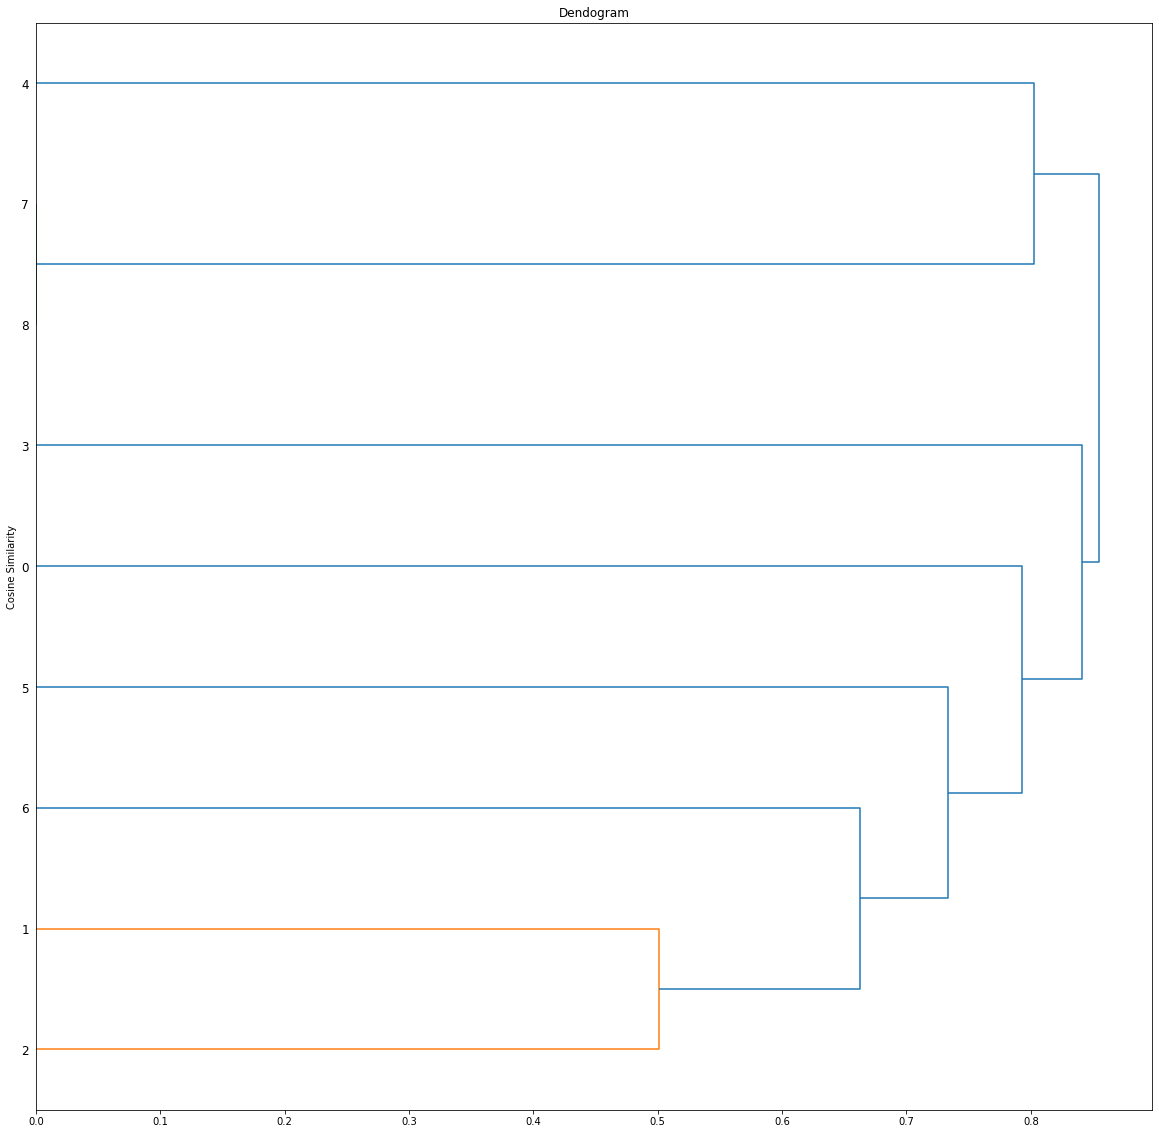

In [14]:
clustering = Clustering_Visualization(uid_sentence_embed_pair)
clustering.dendrogram_draw()

In [15]:
labels_out = clustering.k_means_labels(uid_problem_pair)

Printing the cluster labels for all the records whose uid start with WO total record number under this category is 9

[1 1 1 1 0 1 1 0 0]
1:  UID:WO2019201595A1     Problem:difficult insert coil narrow coil width side side coil formation
1:  UID:WO2020088956A1     Problem:undesirable torque harmonic output power harmonic electrical machine
1:  UID:WO2016162135A1     Problem:grounding low speed synchronous machine high torque
1:  UID:WO2018059798A1     Problem:gas turbine emission form exhaust gas typically higher transient mode
0:  UID:WO2020094470A1     Problem:ac loss
1:  UID:WO2020048732A1     Problem:surface generator may damaged
1:  UID:WO2018134044A1     Problem:difficult cool stator external rotor generator
0:  UID:WO2018041541A1     Problem:electrical energy must transported long distance
0:  UID:WO2018028868A1     Problem:electrical energy must transported long distance


Scatter plot for records whose uid start with WO

Records with their respective cluster labels are plotted using a Scatter plot.
For dimentionality reduction of matrix containing sentence embeddings, we have used Principal Component Analysis.
 X denotes cluster centers in the scatter plot.


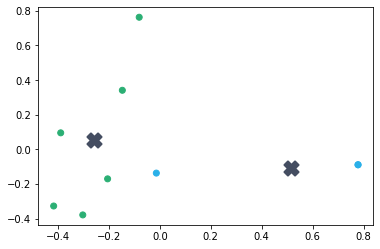

In [16]:
clustering.k_means_clustering(labels = labels_out[0], clf = labels_out[1])

##The next four blocks corresponds to showing dendogram, extracted_problems and their cluster numbers and a scatter plot of K-means clustering for uids staring with DE. 

In [17]:
embed = Sentence_Embedding(df, 'DE', 'mpnet')
uid_problem_pair = embed.uid_problem_pair()
uid_sentence_embed_pair = embed.sentence_embed(uid_problem_pair)

Number of records under uid starting with DE is 26
Shape of 26 embedded sentences is (26, 768)


Hierarchical clustering of records whose uid start with DE


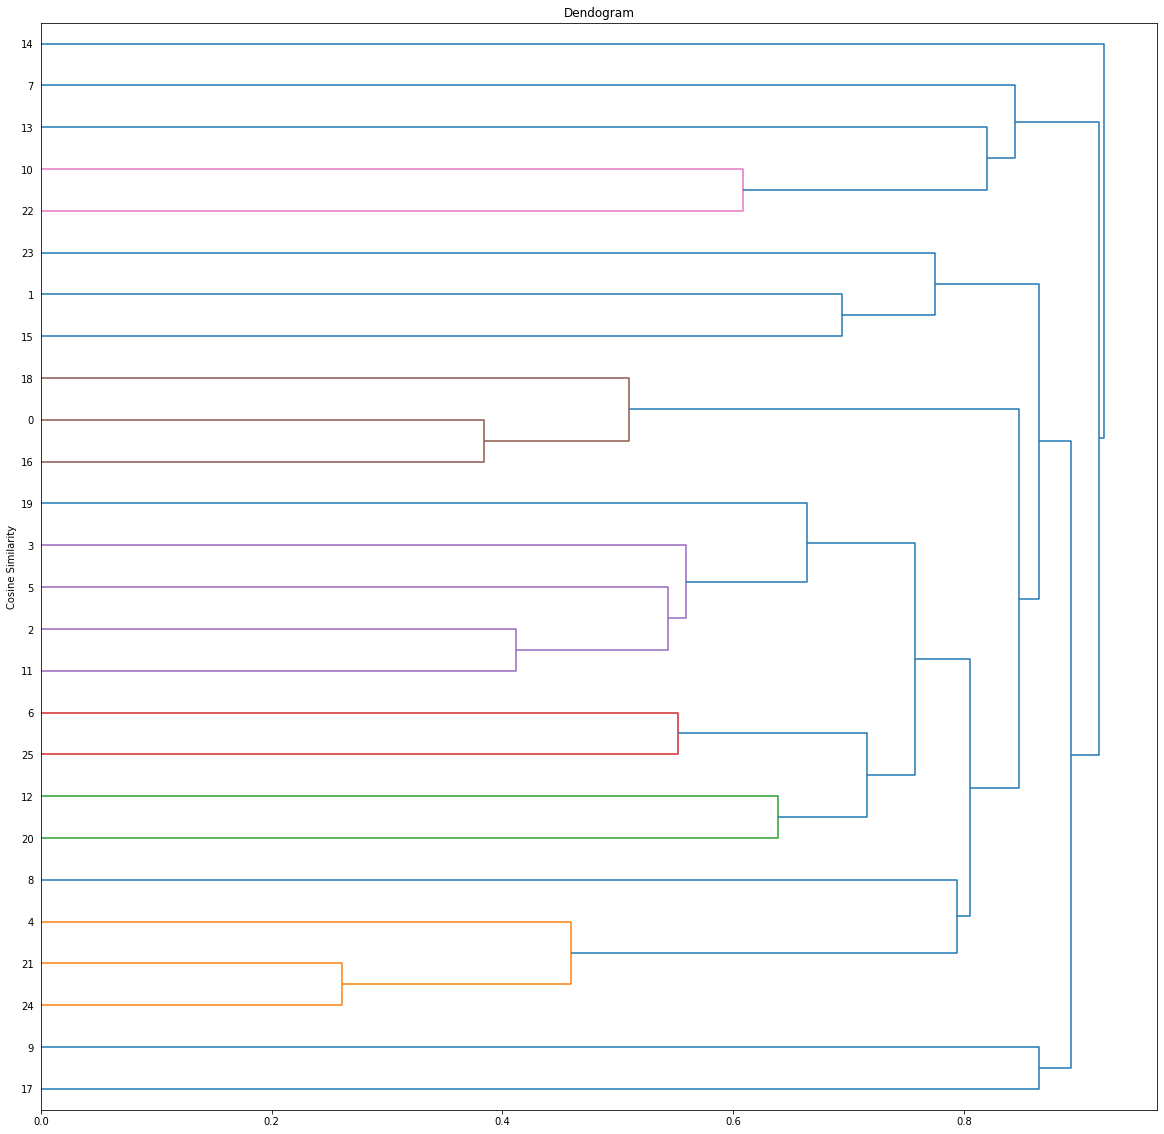

In [18]:
clustering = Clustering_Visualization(uid_sentence_embed_pair)
clustering.dendrogram_draw()

In [19]:
labels_out = clustering.k_means_labels(uid_problem_pair)

Printing the cluster labels for all the records whose uid start with DE total record number under this category is 26

[2 3 3 3 3 3 1 0 1 1 3 3 1 3 2 0 2 2 2 3 1 1 0 3 2 3]
2:  UID:DE102009032881A1     Problem:assembly increasingly difficult transport logistics
3:  UID:DE102012206867A1     Problem:greater larger entire generator
3:  UID:DE102010038922A1     Problem:attachment permanent magnet rotor body major manufacturing challenge
3:  UID:DE102012218795A1     Problem:handling corresponding stator rotor element often problematic
3:  UID:DE10250382A1     Problem:large diameter generator well big one air gap
3:  UID:DE102015201959A1     Problem:geometry machined rotor yoke cause problem extreme situation
1:  UID:DE102013206572A1     Problem:reduced average torque torque ripple
0:  UID:DE102013226103A1     Problem:supply consumer low voltage source
1:  UID:DE112011103863T5     Problem:likelihood bearing failure
1:  UID:DE60004845T2     Problem:largely constant speed
3:  UID:DE10201821678

Scatter plot for records whose uid start with DE

Records with their respective cluster labels are plotted using a Scatter plot.
For dimentionality reduction of matrix containing sentence embeddings, we have used Principal Component Analysis.
 X denotes cluster centers in the scatter plot.


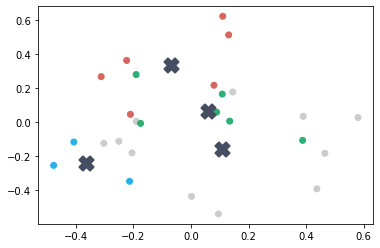

In [20]:
clustering.k_means_clustering(labels = labels_out[0], clf = labels_out[1])

##The next four blocks corresponds to showing dendogram, extracted_problems and their cluster numbers and a scatter plot of K-means clustering for uids staring with EP. 

In [21]:
embed = Sentence_Embedding(df, 'EP', 'mpnet')
uid_problem_pair = embed.uid_problem_pair()
uid_sentence_embed_pair = embed.sentence_embed(uid_problem_pair)

Number of records under uid starting with EP is 69
Shape of 69 embedded sentences is (69, 768)


Hierarchical clustering of records whose uid start with EP


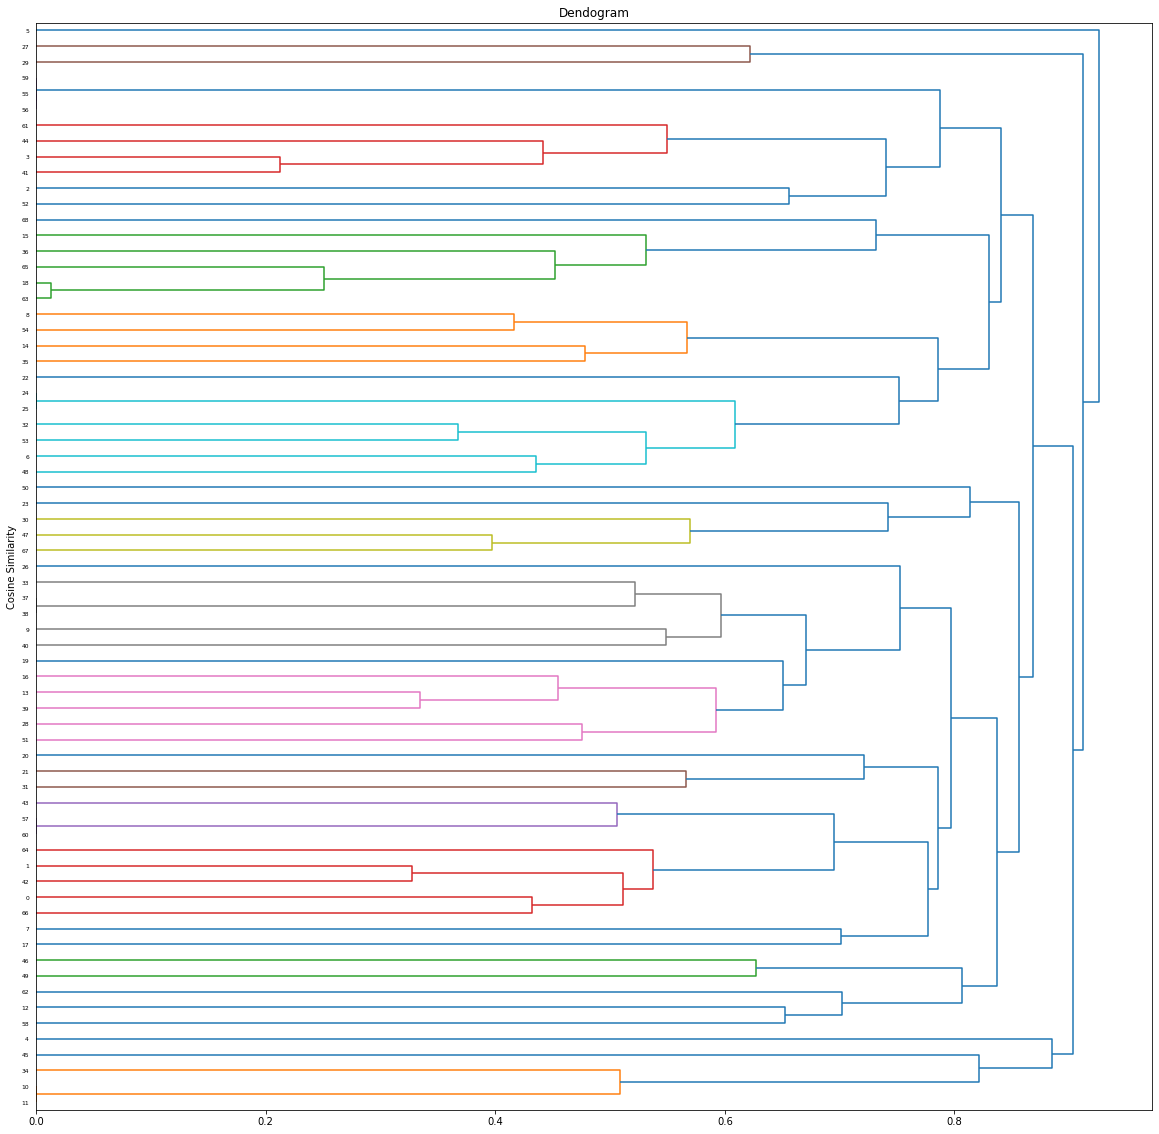

In [22]:
clustering = Clustering_Visualization(uid_sentence_embed_pair)
clustering.dendrogram_draw()

In [23]:
labels_out = clustering.k_means_labels(uid_problem_pair)

Printing the cluster labels for all the records whose uid start with EP total record number under this category is 69

[3 3 5 5 3 3 2 1 2 3 1 1 3 3 2 4 3 2 4 3 1 1 2 3 2 2 3 3 3 3 3 3 2 1 1 2 4
 3 3 3 2 5 3 3 5 2 0 3 2 0 1 3 5 2 2 5 5 3 2 5 3 5 0 4 3 4 3 3 5]
3:  UID:EP3273578B1     Problem:efficient cooling made difficult compact design drive end
3:  UID:EP3531540A1     Problem:cooling electrical generator
5:  UID:EP2896824B1     Problem:mechanical brake system
5:  UID:EP3614556A1     Problem:torque ripple
3:  UID:EP3270491A1     Problem:difficult cool
3:  UID:EP2510229B1     Problem:find way conduct electrical current lightning strike onto blade blade
2:  UID:EP2747252B1     Problem:accessibility difficult order maintain bearing engageable surface
1:  UID:EP2166644B1     Problem:double layer winding difficult mount
2:  UID:EP2747273B1     Problem:practically difficult manufacture tolerance non uniform material structure deformation
3:  UID:EP2669512B1     Problem:difficult ground bea

Scatter plot for records whose uid start with EP

Records with their respective cluster labels are plotted using a Scatter plot.
For dimentionality reduction of matrix containing sentence embeddings, we have used Principal Component Analysis.
 X denotes cluster centers in the scatter plot.


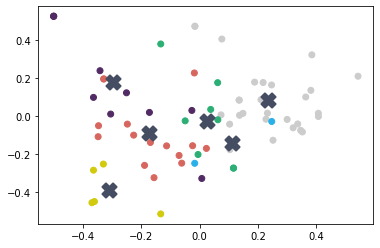

In [24]:
clustering.k_means_clustering(labels = labels_out[0], clf = labels_out[1])

##The next four blocks corresponds to showing dendogram, extracted_problems and their cluster numbers and a scatter plot of K-means clustering for uids staring with US. 

In [25]:
embed = Sentence_Embedding(df, 'US', 'mpnet')
uid_problem_pair = embed.uid_problem_pair()
uid_sentence_embed_pair = embed.sentence_embed(uid_problem_pair)

Number of records under uid starting with US is 43
Shape of 43 embedded sentences is (43, 768)


Hierarchical clustering of records whose uid start with US


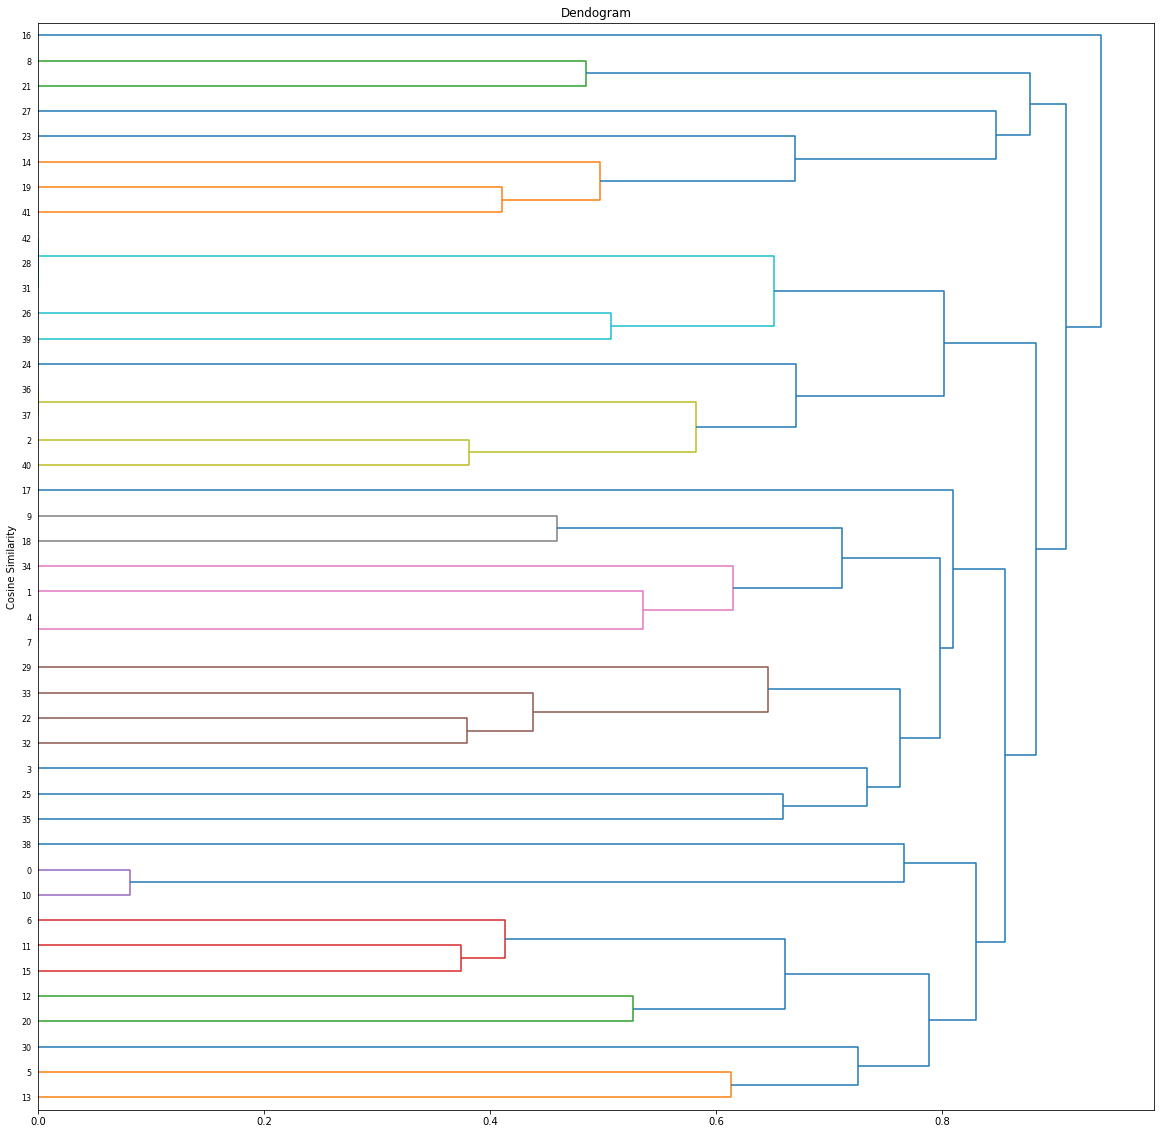

In [26]:
clustering = Clustering_Visualization(uid_sentence_embed_pair)
clustering.dendrogram_draw()

In [27]:
labels_out = clustering.k_means_labels(uid_problem_pair)

Printing the cluster labels for all the records whose uid start with US total record number under this category is 43

[1 0 4 0 2 3 3 2 2 2 1 3 4 1 0 3 1 0 2 0 3 0 1 1 2 2 4 4 4 1 3 4 1 1 4 0 4
 4 4 4 4 0 4]
1:  UID:US20200059181A1     Problem:vibration noise
0:  UID:US8629596B2     Problem:make laying form wound coil slot difficult
4:  UID:US9698653B2     Problem:large gastoair gastowater heat exchanger needed
0:  UID:US20140314580A1     Problem:difficult iron casted one piece
2:  UID:US20140193264A1     Problem:pad used cylindrical bearing surface large heavy difficult exchange
3:  UID:US8084876B2     Problem:transport generator construction site
3:  UID:US8994200B2     Problem:wind turbine generator response grid requirement
2:  UID:US9797378B2     Problem:pad used cylindrical bearing surface large heavy difficult exchange
2:  UID:US10374538B2     Problem:introduction filter may tend undermine system stability
2:  UID:US9906099B2     Problem:mechanical brake system
1:  UID:US2019027

Scatter plot for records whose uid start with US

Records with their respective cluster labels are plotted using a Scatter plot.
For dimentionality reduction of matrix containing sentence embeddings, we have used Principal Component Analysis.
 X denotes cluster centers in the scatter plot.


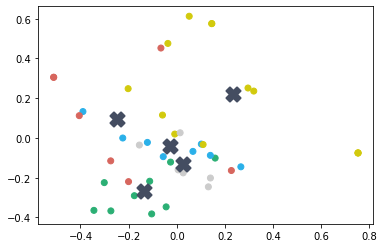

In [28]:
clustering.k_means_clustering(labels = labels_out[0], clf = labels_out[1])

##The next four blocks corresponds to showing dendogram, extracted_problems and their cluster numbers and a scatter plot of K-means clustering for uids staring with JP. 

In [29]:
embed = Sentence_Embedding(df, 'JP', 'mpnet')
uid_problem_pair = embed.uid_problem_pair()
uid_sentence_embed_pair = embed.sentence_embed(uid_problem_pair)

Number of records under uid starting with JP is 9
Shape of 9 embedded sentences is (9, 768)


Hierarchical clustering of records whose uid start with JP


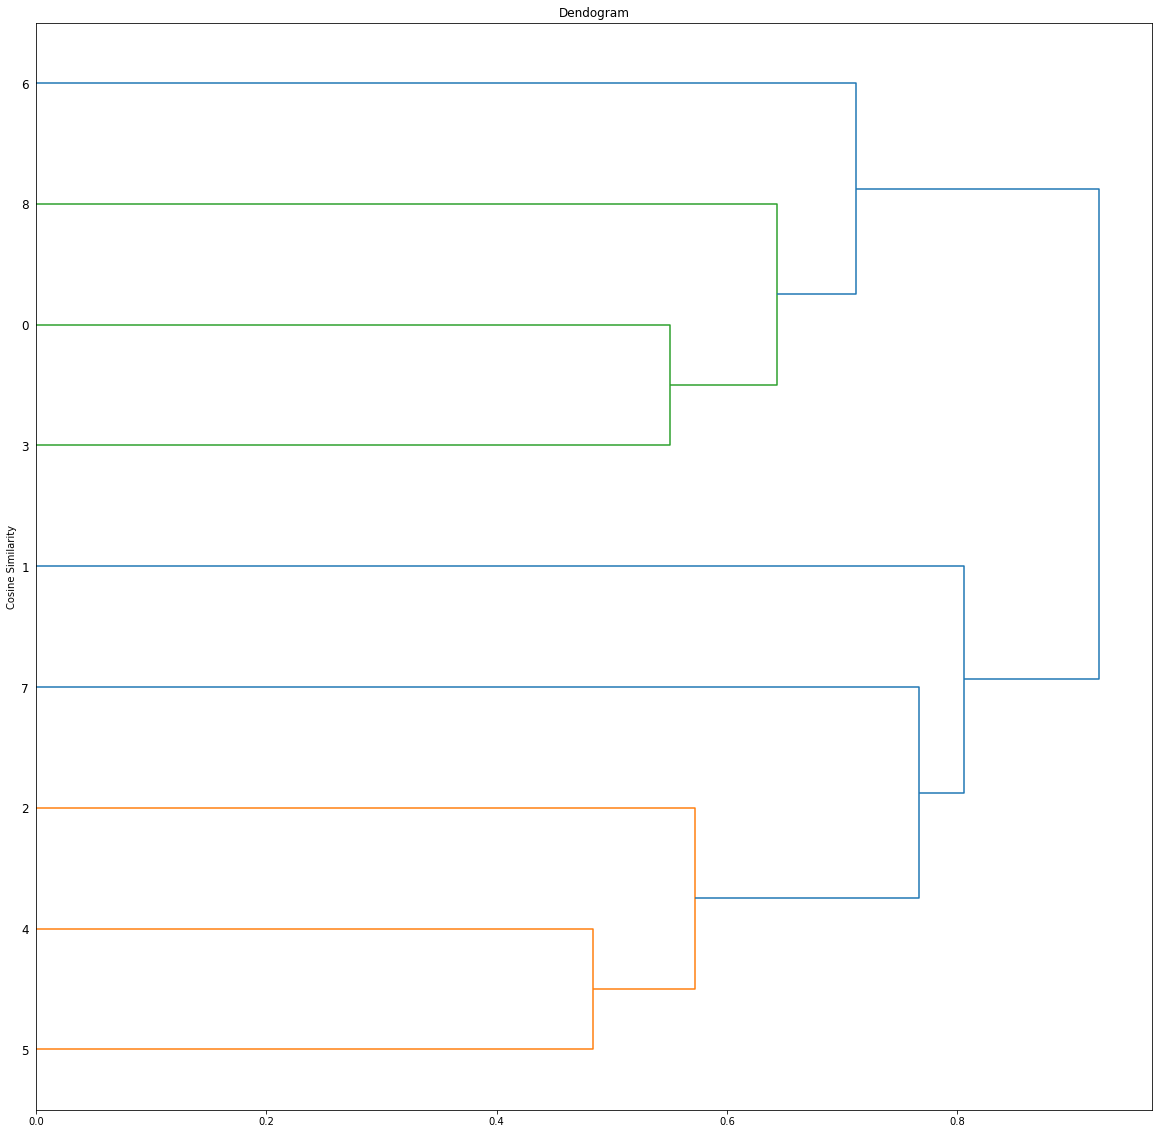

In [30]:
clustering = Clustering_Visualization(uid_sentence_embed_pair)
clustering.dendrogram_draw()

In [31]:
labels_out = clustering.k_means_labels(uid_problem_pair)

Printing the cluster labels for all the records whose uid start with JP total record number under this category is 9

[1 0 0 1 0 0 1 0 1]
1:  UID:JP2012516666A     Problem:wind generator response utility network demand usually black box
0:  UID:JP2010148350A     Problem:stability problem
0:  UID:JP2003143899A     Problem:drawback associated slip ring occur
1:  UID:JP5773621B2     Problem:provide advantageous generator
0:  UID:JP2012092970A     Problem:large looseness bearing problem side smear promote roller adhesive wear
0:  UID:JP6124508B2     Problem:inner ring bearing heated expands
1:  UID:JP4073956B2     Problem:control system controlling rotational speed power generation turbine
0:  UID:JP2011152035A     Problem:cogging torque
1:  UID:JP2001526357A     Problem:power generation performed chimney effect passage


Scatter plot for records whose uid start with JP

Records with their respective cluster labels are plotted using a Scatter plot.
For dimentionality reduction of matrix containing sentence embeddings, we have used Principal Component Analysis.
 X denotes cluster centers in the scatter plot.


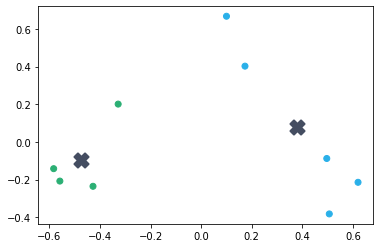

In [32]:
clustering.k_means_clustering(labels = labels_out[0], clf = labels_out[1])